# Lithography Aerial mask simulation Simulation with Python - Notebook

In this notebook we present some insights about the simulation of the **lithographic process**. 



In [ ]:
# Parameters
Accuracy = 7: #Degree of accuracy (integezr, higher means more time more accurate)
N = 2^Accuracy + 1: ##Resolution
lamda= 0.1:   #Wavelength (um) 
TH =0.4:  #Threshold intensity (normalized)
NA= 0.85.   #Numerical aperature
L=0.09; #Smallest possible length 



<center><img src="img/aerialmask.png" width="400" /></center>
<center><img src="img/aeriallight.png" width="400" /></center>

<h3 align="center">Some illustrations of what we will achieve at the end of this notebook.</h3>

## Aerial image formulation

There is a lot to say about the theory of imaging, but in this notebook we will directly go to the imaging equation that describe the optical aspect of photolithography. In the framework of Fourier optics and scalar diffraction theory the intensity received by a substrate is written as :

$$I(x,y)=\idotsint_{\infty}^{-\infty} \tilde{J}(f,g)\tilde{H}(f+f',g+g')\tilde{H}^*(f+f'',g+g'')\tilde{O}(f',g')\tilde{O}(f'',g'') \\ 
	e^{-2i\pi[(f'-f'')x+(g'-g'')y]}dfdgdf'dg'df''dg''$$

All functions will be defined in the next sections, but we can already name them:
- $\tilde{J}(f,g)$ is the effective source, it represents the spectrum of plane waves incident on the mask.
- $\tilde{H}(f,g)$ is the projection lens transfer function, it represents the frequency cutoff applied by the projection lens aperture to the mask spectrum but also the lens aberrations.
- $\tilde{O}(f,g)=\mathcal{F}[O]$ is the mask Fourier transform (also called mask spectrum)

The $\tilde{}$ notation means that the function is expressed in the frequency domain.
Two numerical implentations are possible to compute this equation: the Abbe and Hopkins approach.
Before giving the numerical implementation each function of the imaging equation will be described.

*References*
- [M., & Wolf, E. (2013). Principles of optics: electromagnetic theory of propagation, interference and diffraction of light. Elsevier.](https://www.cambridge.org/core/books/principles-of-optics/D12868B8AE26B83D6D3C2193E94FFC32)
- [Goodman, J. W. (2005). Introduction to Fourier optics. Roberts and Company Publishers.](http://www.opticsjournal.net/post/ifo.pdf)

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

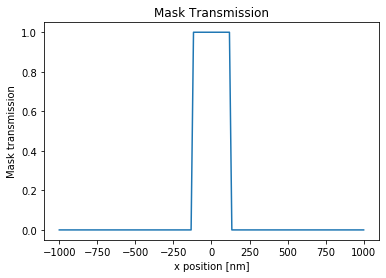

In [1163]:
# Define the chromium dot size in nanometers
dot_size=250.
# Define the mask support (x support)
# Since we compute FT, better to chose a 2^n number of points
x_support=np.linspace(-1000.,1000.,128)
# Compute the pixel size in nanometers
dx=2000./128
# Define the mask, 1 for glass, 0 for chromium
mask=[1 if np.abs(x)<dot_size/2 else 0 for x in x_support]
# Plot
plt.title('Mask Transmission')
plt.plot(x_support, mask)
plt.xlabel('x position [nm]')
plt.ylabel('Mask transmission')
plt.show()

From there we compute **the Fourier Transform** of the mask.  
With numeric Fourier Transform one has to use the shift function to recenter the low frequency at the center for both spectrum and support. With also compute the analytic Fourier Transform of the mask: the Fourier Transform of a hole is a sinc function <font color=red>(Careful for normalisation, do not forget pixel size !)</font>.

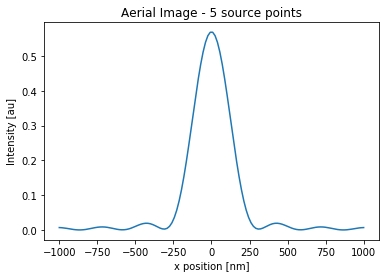

In [1167]:
compute_abbe(sigma=0.7,NA=0.57,wavelength=365.,mask_ft=mask_ft,frq=freq_support,make_plots=True)

Another common benchmark is to compute the aerial image of a knife edge also called Heavyside function.

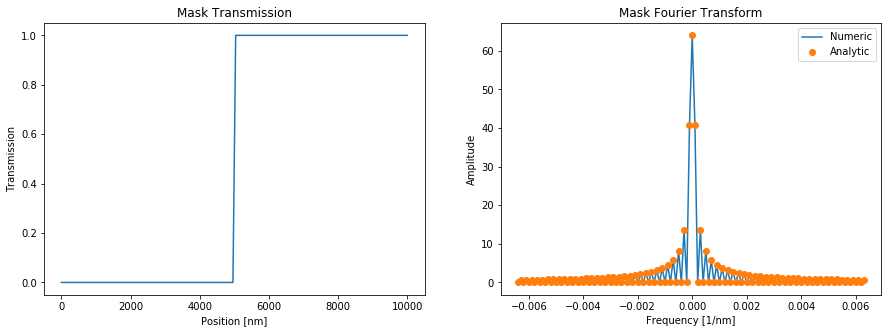

In [ ]:
# Heavyside mask creation
n_pts=128
x_suppt_heavyside=np.linspace(0,10000.,n_pts)
mask_heavyside=[1 if x>=5000 else 0 for x in x_suppt_heavyside]
# Pixel size in nanometers
dx_heavyside=10000./n_pts
# Computation of the mask TF and its frequency support
mask_ft_heavyside=np.fft.fftshift(np.fft.fft(mask_heavyside))
freq_support_heavyside=np.fft.fftshift(np.fft.fftfreq(n_pts,d=dx_heavyside))
# Analytical Fourier Transform first shift, then TF
mask_ana_ft_heavyside=np.exp(-1j * 2. * np.pi * freq_support_heavyside * 2500)
mask_ana_ft_heavyside*=np.sinc(freq_support_heavyside * 5000.)*5000./dx_heavyside
# Plotting section
fif,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].set_title('Mask Transmission')
ax[0].plot(x_suppt_heavyside,mask_heavyside)
ax[0].set_xlabel('Position [nm]')
ax[0].set_ylabel('Transmission')
# FT plot
ax[1].set_title('Mask Fourier Transform')
ax[1].plot(freq_support_heavyside,np.abs(mask_ft_heavyside),label='Numeric')
ax[1].plot(freq_support_heavyside,np.abs(mask_ana_ft_heavyside),'o',label='Analytic')
ax[1].set_xlabel('Frequency [1/nm]')
ax[1].set_ylabel('Amplitude')
ax[1].legend()
plt.show()

Let's compute the aerial image for different source coherence to show the impact of this parameter:

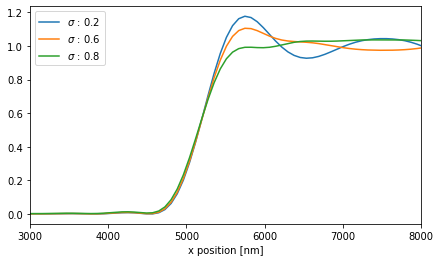

In [1169]:
plt.figure(figsize=(7,4))
# Loop over different coherence values
for sigma in [0.2, 0.6, 0.8]:
    aerial_image_heavyside=compute_abbe(sigma=sigma,NA=0.28,wavelength=436.,mask_ft=mask_ft_heavyside,frq=freq_support_heavyside)
    plt.plot(x_suppt_heavyside,aerial_image_heavyside,label=f'$\sigma$ : {sigma}')
plt.xlim(3000.,8000.)
plt.xlabel('Intensity')
plt.xlabel('x position [nm]')
plt.legend()
plt.show()

We can compare our model result with the plot of the original article:

- [O'Toole, M. M., & Neureuther, A. R. (1979). *Influence of partial coherence on projection printing. In Developments in Semiconductor Microlithography IV* (Vol. 174, pp. 22-27). International Society for Optics and Photonics.](https://spie.org/Publications/Proceedings/Paper/10.1117/12.957174)


<img src="img/neureuther_coherence_heavyside.PNG" width="500" />

In the general case the development path is not strictly vertical. In this situation, the use of **fast marching algorithm** is required. The fast marching algorithm is an iterative solver for the eikonal equation. It requires an oriented field (for the propgation direction) and a speed field. The algorithm computes the time required for the speed field to reach each point in the field. This approach was initially proposed by Sethian, see reference:

*Reference*
- [Sethian, J. A. (1996, June). Fast-marching level-set methods for three-dimensional photolithography development. In Optical Microlithography IX (Vol. 2726, pp. 262-272). International Society for Optics and Photonics.](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/2726/0000/Fast-marching-level-set-methods-for-three-dimensional-photolithography-development/10.1117/12.240962.short?SSO=1)

Computation with fast marching algorithm is shown below:

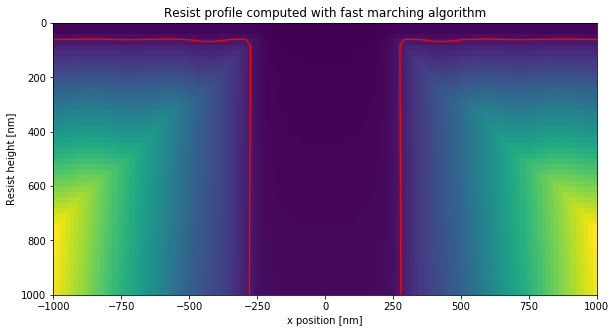

In [1179]:
import skfmm
# Fast Marching require a negative frontier to compute travel time
# We add this frontier artifically (it will be removed later)
neg_layer = -1 * np.ones_like(lat_img[0, :])
lat_img = np.vstack((lat_img, neg_layer))
cur_dev_rate = np.vstack((neg_layer, cur_dev_rate))
# Compute fast marching (! the algorithm flips the array along axis 0)
time_resist_fmm = skfmm.travel_time(lat_img, cur_dev_rate, dx=[dz, dx],periodic=[False,True])
# Remove artificial negative layer
time_resist_fmm=time_resist_fmm[1:,:]
# Flip array back to normal
time_resist_fmm=np.rot90(time_resist_fmm,k=2)
# Plotting
fig,ax=plt.subplots(1,1,figsize=(12,5))
ax.set_title('Resist profile computed with fast marching algorithm')
ax.imshow(time_resist_fmm, extent=[np.min(x_support) , np.max(x_support), thickness ,0])
ax.contour(X,Z,time_resist_fmm,levels=[60,],colors='r')
ax.set_xlabel('x position [nm]')
ax.set_ylabel('Resist height [nm]')
plt.show()

Next we plot the two resist profiles on the same graph to highlight the differences:

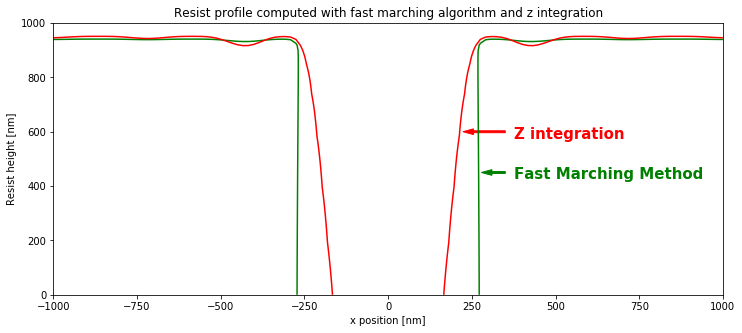

In [1180]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
ax.set_title('Resist profile computed with fast marching algorithm and z integration')
ax.contour(X,Z,time_resist[::-1,:],levels=[60,],colors='g')
ax.arrow(350,450,-40,0,color='g',width=7)
ax.text(375, 425, 'Fast Marching Method',color='g',weight='bold',size=15)
ax.contour(X,Z,time_resist_z[::-1,:],levels=[60,],colors='r')
ax.arrow(350, 600,-95,0,color='r',width=7)
ax.text(375,575, 'Z integration',color='r',weight='bold',size=15)
ax.set_xlabel('x position [nm]')
ax.set_ylabel('Resist height [nm]')
plt.show()